# Acrescentando perfis de deputados concorrendo à reeleição

[Voltar ao Índice](00_indice.ipynb)

Percebemos que muitos candidatos possuem perfis no twitter mas não os declaram ao TSE. 
Por outro lado, é bem mais comum eles declararem perfis no Instagram. Em vários casos, os nomes dos perfis são iguais. 
Portanto, adotamos a estratégia de verificar se o nome do Instagram também existe no twitter, e utilizar um modelo de
machine learning para selecionar aqueles mais prováveis de realmente corresponder ao candidato (i.e. evitar homônimos).


In [53]:
import pandas as pd

import xavy.twitter as tw
import xavy.explore as xe
import xavy.dataframes as xd

## Funções

In [10]:
def request_twitter_user_info(df, username_col='twitter_username', cand_id_col='SQ_CANDIDATO', requests_per_window=900):
    """
    Collect twitter user info using Twitter
    API v.1.1.
    
    Parameters
    ----------
    df : DataFrame
        Table containing the twitter username 
        and a candidate identifier (e.g. 
        'SQ_CANDIDATO').
    username_col : str
        Name of the column containing the 
        twitter usernames.
    cand_id_col : str
        Column identifying the candidate.
    requests_per_window : int
        Maximum number of requests allowed
        by the API in a 15-minute window.
    
    Returns
    -------
    response_df : DataFrame
        DataFrame with all the information
        provided by the API, for each 
        username found, along with the 
        associated candidate ID.
    """
    
    # Look for twitter IDs with API:
    w_username = df[username_col].dropna().drop_duplicates()
    response = tw.lookup(w_username, requests_per_window=requests_per_window)
    
    # Build DataFrame with responses:
    response_df = pd.DataFrame(response['data'])
    
    # Expand dict Series (nested data):
    for col in response_df.columns:
        if type(response_df[col].iloc[0]) is dict:
            nested_df = pd.DataFrame(list(response_df[col]), index=response_df.index)
            response_df = response_df.join(nested_df)
            response_df.drop(col, axis=1, inplace=True)
    
    return response_df

## Juntando IDs

In [2]:
# Carregando os dados:
perfis_df = pd.read_csv('../dados/processados/perfis_twitter_deputados_reeleicao2022_LagomData.csv')
perfis_df['lowercase'] = perfis_df['Twitter'].str.lower()

### Explorando tabela de perfis

In [26]:
xe.checkMissing(perfis_df)

Colunas com valores faltantes:
      coluna    N     %
7  na arroba  1.0  0.24
8     na bio  1.0  0.24
9  na imagem  1.0  0.24


In [27]:
xe.find_double_entries(perfis_df, 'Twitter')

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,SG_PARTIDO,SG_UE,Twitter,quantas vezes identifica partido,na arroba,na bio,na imagem,filiação,lowercase
18,200001603652,NATÁLIA BASTOS BONAVIDES,NATÁLIA BONAVIDES,PT,RN,natbonavides,2,n,s,s,Mesmo partido de 2018,natbonavides
114,200001603652,NATÁLIA BASTOS BONAVIDES,NATÁLIA BONAVIDES,PT,RN,natbonavides,1,n,s,n,Mesmo partido de 2018,natbonavides
65,220001604140,LUCIO ANTONIO MOSQUINI,LUCIO MOSQUINI,MDB,RO,luciomosquini,0,n,n,n,Mesmo partido de 2018,luciomosquini
108,220001604140,LUCIO ANTONIO MOSQUINI,LUCIO MOSQUINI,MDB,RO,luciomosquini,0,n,n,n,Mesmo partido de 2018,luciomosquini
19,180001601221,JOSÉ FRANCISCO PAES LANDIM,PAES LANDIM,UNIÃO,PI,PaesLandim4,0,n,n,n,Informou que pulou a janela depois de maio,paeslandim4
101,180001601221,JOSÉ FRANCISCO PAES LANDIM,PAES LANDIM,UNIÃO,PI,PaesLandim4,0,n,n,n,Informou que pulou a janela depois de maio,paeslandim4


In [28]:
xe.find_double_entries(perfis_df, 'SQ_CANDIDATO')

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,SG_PARTIDO,SG_UE,Twitter,quantas vezes identifica partido,na arroba,na bio,na imagem,filiação,lowercase
65,220001604140,LUCIO ANTONIO MOSQUINI,LUCIO MOSQUINI,MDB,RO,luciomosquini,0,n,n,n,Mesmo partido de 2018,luciomosquini
108,220001604140,LUCIO ANTONIO MOSQUINI,LUCIO MOSQUINI,MDB,RO,luciomosquini,0,n,n,n,Mesmo partido de 2018,luciomosquini
18,200001603652,NATÁLIA BASTOS BONAVIDES,NATÁLIA BONAVIDES,PT,RN,natbonavides,2,n,s,s,Mesmo partido de 2018,natbonavides
114,200001603652,NATÁLIA BASTOS BONAVIDES,NATÁLIA BONAVIDES,PT,RN,natbonavides,1,n,s,n,Mesmo partido de 2018,natbonavides
19,180001601221,JOSÉ FRANCISCO PAES LANDIM,PAES LANDIM,UNIÃO,PI,PaesLandim4,0,n,n,n,Informou que pulou a janela depois de maio,paeslandim4
101,180001601221,JOSÉ FRANCISCO PAES LANDIM,PAES LANDIM,UNIÃO,PI,PaesLandim4,0,n,n,n,Informou que pulou a janela depois de maio,paeslandim4


In [31]:
xe.one2oneViolations(perfis_df, 'SQ_CANDIDATO', 'lowercase')

Series([], Name: lowercase, dtype: object)

In [32]:
xe.one2oneViolations(perfis_df, 'lowercase', 'SQ_CANDIDATO')

Series([], Name: SQ_CANDIDATO, dtype: object)

### Coletando IDs

In [15]:
# Coletando IDs:
x1 = request_twitter_user_info(perfis_df, 'lowercase')
x1['lowercase'] = x1['username'].str.lower()

In [21]:
# Juntando com dados originais:
final_df = perfis_df.join(x1.set_index('lowercase'), on='lowercase')
final_df['id'] = final_df['id'].astype(str)

In [22]:
# Exportando os dados:

#final_df.to_csv('../dados/processados/perfis_twitter_deputados_reeleicao2022_LagomData+IDsCeweb.csv', index=False)

#### Deputados que deram erro na captura (hard-coded)

In [10]:
#response['errors']

[{'value': 'dep_ledasadala',
  'detail': 'Could not find user with usernames: [dep_ledasadala].',
  'title': 'Not Found Error',
  'resource_type': 'user',
  'parameter': 'usernames',
  'resource_id': 'dep_ledasadala',
  'type': 'https://api.twitter.com/2/problems/resource-not-found'},
 {'value': 'cassio_40',
  'detail': 'Could not find user with usernames: [cassio_40].',
  'title': 'Not Found Error',
  'resource_type': 'user',
  'parameter': 'usernames',
  'resource_id': 'cassio_40',
  'type': 'https://api.twitter.com/2/problems/resource-not-found'}]

## Juntando com o que já tenho

In [51]:
cand22_df = pd.read_csv('../dados/limpos/consulta_cand/consulta_cand_2022_BRASIL.csv', low_memory=False)

In [25]:
twitter_ids_df = pd.read_csv('../dados/processados/twitter+insta_ids_deputados_2022.csv')

In [84]:
# Cria tabela com novos dados:
new_ids = set(final_df['id'].astype(str)) - set(twitter_ids_df['id'].astype(str))
final_sel_cols = ['SQ_CANDIDATO', 'name', 'protected', 'username', 'description', 'id', 'verified', 'created_at', 'withheld', 'followers_count', 'following_count', 'tweet_count', 'listed_count']
new_ids_df = final_df.loc[final_df['id'].isin(new_ids)].drop_duplicates(subset=['SQ_CANDIDATO', 'id'])[final_sel_cols].copy()
new_ids_df['source'] = 'lagom'
new_ids_df['sample_weight'] = 1.0
new_ids_df['lower_name'] = new_ids_df['username'].str.lower()
new_ids_df['DS_URL'] = 'https://www.twitter.com/' + new_ids_df['username']
new_ids_df = new_ids_df.dropna(subset=['username'])

In [86]:
# Junta com informações do candidato:
joined_df = new_ids_df.join(cand22_df.set_index('SQ_CANDIDATO'), on='SQ_CANDIDATO')
joined_df = joined_df[twitter_ids_df.columns]

In [154]:
# Concatena com o que já tinha:
concat_df = pd.concat([twitter_ids_df, joined_df], ignore_index=True)
# Remove perfis errados/withelds:
concat_df['id'] = concat_df['id'].astype(int)
manual_id_drop = {36971658, 195931773, 186201239, 186201239, 41056416, 277536738, 1281590900834078720, 330770436, 1907851698}
concat_df = concat_df.loc[~concat_df['id'].isin(manual_id_drop)]

In [157]:
tot_w = concat_df.groupby('SQ_CANDIDATO')['sample_weight'].sum().sort_values()
tot_w.max()

1.0

### Verificando perfis do insta

In [160]:
insta_df = concat_df.loc[concat_df['source'] == 'instagram'].copy()

In [168]:
insta_df['label'] = insta_df['SQ_CANDIDATO'].astype(str) + ' / ' + insta_df['id'].astype(str) + ': ' + insta_df['NM_URNA_CANDIDATO'] + ' (' + insta_df['SG_PARTIDO'] + '-' + insta_df['SG_UF'] + ')'
insta_df['url'] = 'https://www.twitter.com/' + insta_df['username'] + ' ' + insta_df['DS_URL']
xd.print_string_series(insta_df.set_index('label')['url'].sample(50, random_state=569))

150001621585 / 18274541: WELLINGTON SOUSA (REDE-PB): https://www.twitter.com/wellingtonsousa https://instagram.com/wellingtonsousa
190001603398 / 347165805: KARLA DE LUCAS DOS BICHINHOS (PSD-RJ): https://www.twitter.com/KarladeLucas https://www.instagram.com/karladelucas/
130001607379 / 365161938: EDSON SORÓ (PT-MG): https://www.twitter.com/EdsonSoro https://www.instagram.com/edsonsoro/
170001620395 / 166412470: DIOGO MORAES (PSB-PE): https://www.twitter.com/DiogoMoraesPSB https://www.instagram.com/diogomoraespsb/
110001612759 / 1149131923652063232: NELSON BARBUDO (PL-MT): https://www.twitter.com/nelsonbarbudo https://www.instagram.com/nelsonbarbudo/
60001633795 / 43147601: JACK LIMA (PL-CE): https://www.twitter.com/Jack_lima https://www.instagram.com/jack_lima/
190001613875 / 109569750: LUIS BIBÃO (PMN-RJ): https://www.twitter.com/luisbibao https://instagram.com/luisbibao?igshid=YmMyMTA2M2Y=
250001610293 / 132394985: WANESSA BOMFIM  (PODE-SP): https://www.twitter.com/wanessabomfim htt

### Exportando

In [176]:
# Encontramos 11 errados dentre 50: 78% +/- 5%.
bad_insta = {18274541, 347165805, 43147601, 132394985, 188804690, 10683772, 41141649, 65361736, 427046619, 5746372, 516824885}
concat_clean_df = concat_df.loc[~concat_df['id'].isin(bad_insta)]

In [186]:
len(concat_clean_df)

3474

In [185]:
#concat_clean_df.to_csv('../dados/processados/twitter+insta+lagom_ids_deputados_2022.csv', index=False)

# Usando usuários do instagram para achar contas no twitter

In [18]:
import pandas as pd
from glob import glob
import re
from pathlib import Path

import xavy.twitter as tw
from xavy.dataframes import print_string_series
import xavy.explore as xe

## Funções

In [19]:
def extract_twitter_username(series, lower=True):
    """
    Given a Series that contains the URL 
    or the username of twitter accounts,
    extract the username.
    
    If `lower` is True, return lower case
    username (Twitter usernames are not 
    case-sensitive).
    
    Returns a series with same index as 
    the input. NaN is returned when no
    unsername is found.
    """
    
    #cleaned = series
    cleaned  = series.str.replace(r'https?:/+(?:www\.)?twitter\.com/https?:/*', 'https://', regex=True)
    cleaned  = cleaned.str.replace(r'https?:/+(?:www\.)?twitter\.com/www.twitter.com*', 'https://www.twitter.com', regex=True)
    cleaned  = cleaned.str.replace(r'www\.twitter/', 'www.twitter.com/', regex=True)
    username =  cleaned.str.extract('(?:(?:t[uw]{1,}[ei]{1,}t{1,}w?e{1,}r?|tweet)\.com(?:\.br)?/+[@:]?|@)(\w+)', flags=re.IGNORECASE)[0]
    if lower is True:
        username = username.str.lower()
    
    return username

In [52]:
def extract_instagram_username(series, lower=True):
    """
    Given a Series that contains the URL 
    or the username of twitter accounts,
    extract the username.
    
    If `lower` is True, return lower case
    username (Twitter usernames are not 
    case-sensitive).
    
    Returns a series with same index as 
    the input. NaN is returned when no
    unsername is found.
    """
    
    cleaned  = series
    cleaned  = cleaned.str.replace(r'https?:/+(?:www\.)?instagram\.com/https?:/*', 'https://', regex=True)
    cleaned  = cleaned.str.replace('/accounts/login/?next=/', '/', regex=False)
    cleaned  = cleaned.str.replace('/accounts/', '/', regex=False)
    cleaned  = cleaned.str.replace('/stories/', '/', regex=False, case=False)
    username = cleaned.str.extract(r'(?:[ei][mn]?a?sa?t[sr]?a?[nr]?[qg][rl]e?[am][mn]?|in?s?tragr?[ea][nm]?|is?na?tagra[nm]?|instar?[gr]am)(?:.com)?/?:?@?([a-zA-Z0-9\._]{1,30})', flags=re.IGNORECASE)[0]
    if lower is True:
        username = username.str.lower()
    
    return username

In [21]:
def request_twitter_user_info(df, username_col='twitter_username', cand_id_col='SQ_CANDIDATO', requests_per_window=900):
    """
    Collect twitter user info using Twitter
    API v.1.1.
    
    Parameters
    ----------
    df : DataFrame
        Table containing the twitter username 
        and a candidate identifier (e.g. 
        'SQ_CANDIDATO').
    username_col : str
        Name of the column containing the 
        twitter usernames.
    cand_id_col : str
        Column identifying the candidate.
    requests_per_window : int
        Maximum number of requests allowed
        by the API in a 15-minute window.
    
    Returns
    -------
    response_df : DataFrame
        DataFrame with all the information
        provided by the API, for each 
        username found, along with the 
        associated candidate ID.
    """
    
    # Select unique usernames:
    w_username = df[username_col].dropna().drop_duplicates()
    # Filter out invalid usernames:
    w_username = w_username.loc[w_username.str.contains('^[A-Za-z0-9_]{1,15}$')]
    
    # Look for twitter IDs with API:
    response = tw.lookup(w_username, requests_per_window=requests_per_window)
    # Build DataFrame with responses:
    response_df = pd.DataFrame(response['data'])
    
    # Join SQ_CANDIDATO and other TSE info to twitter data:
    response_df['lower_name'] = response_df['username'].str.lower()
    cand_ids = df.set_index(username_col)
    cand_ids[cand_id_col] = cand_ids[cand_id_col].astype(str)
    response_df = response_df.join(cand_ids, on='lower_name')
    
    # Expand dict Series (nested data containing users metrics):
    for col in response_df.columns:
        if type(response_df[col].iloc[0]) is dict:
            nested_df = pd.DataFrame(list(response_df[col]), index=response_df.index)
            response_df = response_df.join(nested_df)
            response_df.drop(col, axis=1, inplace=True)
    
    return response_df

In [22]:
def build_user_df(redes_df, rede, extract_user):
    
    # Seleciona rede e urls:
    user_df = redes_df.loc[redes_df[rede] == 1][['SQ_CANDIDATO', 'DS_URL']]
    user_df.rename({'DS_URL':'{}_url'.format(rede)}, axis=1, inplace=True)
    # Extrai usuário:
    user_df['{}_user'.format(rede)] = extract_user(user_df['{}_url'.format(rede)])
    # Conta contas:
    n_contas = user_df['SQ_CANDIDATO'].value_counts()
    n_contas.name = 'n_{}'.format(rede)
    user_df = user_df.join(n_contas, on='SQ_CANDIDATO')
    
    return user_df

In [23]:
def get_modelling_info(df, username_col='twitter_username', cand_id_col='SQ_CANDIDATO', requests_per_window=900):

    # Pega info dos usuários do twitter usando o instagram:
    insta_as_twitter = request_twitter_user_info(df, username_col, cand_id_col, requests_per_window)

    unique_insta_as_twitter = insta_as_twitter
    #if 'n_instagram' in insta_as_twitter.columns:
    #    unique_insta_as_twitter = insta_as_twitter.loc[(insta_as_twitter['n_instagram'] == 1) & (insta_as_twitter['n_twitter'] == 1)].copy()
    #else:
    #    unique_insta_as_twitter = insta_as_twitter

    # Prepare data:
    unique_insta_as_twitter['verified'] = unique_insta_as_twitter['verified'].astype(int)
    unique_insta_as_twitter['protected'] = unique_insta_as_twitter['protected'].astype(int)
    # Add time since creation:
    days_created = (pd.to_datetime('2022-08-18') - pd.to_datetime(unique_insta_as_twitter['created_at'], format='%Y-%m-%dT%H:%M:%S.000Z')).dt.total_seconds() / 3600 / 24
    unique_insta_as_twitter['days_created'] = days_created
    # Count digits in name and description:
    unique_insta_as_twitter['digits_name'] = unique_insta_as_twitter['name'].str.extract(r'(\d{2,5})')[0].str.len().fillna(0)
    unique_insta_as_twitter['digits_desc'] = unique_insta_as_twitter['description'].str.extract(r'(\d{2,5})')[0].str.len().fillna(0)
    
    return unique_insta_as_twitter

## Dados para identificação de twitters de candidatos

In [24]:
# Carrega os dados:
cand_df  = pd.read_csv('../dados/limpos/consulta_cand/consulta_cand_2022_BRASIL.csv', low_memory=False)
redes_df = pd.read_csv('../dados/processados/redes_candidatos_2022.csv')

In [53]:
# Pega usuários das redes:
instagram_df = build_user_df(redes_df, 'instagram', extract_instagram_username)
twitter_df   = build_user_df(redes_df, 'twitter', extract_twitter_username)

# Remove URLs sem referência a usuários:
instagram_df = instagram_df.loc[~instagram_df['instagram_url'].str.contains('/p/')]
instagram_df = instagram_df.loc[~instagram_df['instagram_url'].str.contains('/invites/')]
instagram_df = instagram_df.loc[~instagram_df['instagram_url'].str.contains('/tv/')]

In [55]:
# Vamos criar uma tabela com candidatos que declararam twitter E instagram:
comparison_df = instagram_df.merge(twitter_df, how='inner', on='SQ_CANDIDATO')
comparison_df['same'] = (comparison_df['instagram_user'] == comparison_df['twitter_user']).astype(int)
len(comparison_df)

2934

In [56]:
# Quantidade que o nome de usuário é o mesmo:
comparison_df['same'].mean()

0.3149284253578732

In [28]:
# Seleciona apenas candidatos com um só twitter e instagram, para não bagunçar:
one_comparison_df = comparison_df.loc[(comparison_df['n_instagram'] == 1) & (comparison_df['n_twitter'] == 1)]

# Constrói dados para treinar modelo:
unique_insta_as_twitter = get_modelling_info(one_comparison_df, 'instagram_user').drop_duplicates(subset='id')

## Ajustando o Modelo

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

import xavy.mltools as ml
import xavy.text as xt

/home/skems/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [30]:
train_df, test_df = ml.random_set_split(unique_insta_as_twitter, [0.8, 0.2], 563252)
X_train, y_train = ml.Xy_split(train_df, 'same')
X_test, y_test   = ml.Xy_split(test_df, 'same')

In [31]:
# Baseline 0:
ml.print_cv_scores(ml.ConstantPicker(1), X_train, y_train, ['accuracy', 'precision', 'recall'])

accuracy: 0.7389 +/- 0.0217
precision: 0.7389 +/- 0.0217
recall: 1.0000 +/- 0.0000


In [32]:
# Constrói o modelo:
stopwords = xt.return_pt_stopwords()
vec  = CountVectorizer(stop_words=stopwords, min_df=1, binary=False, vocabulary=None)
txt  = Pipeline([('vec', vec)])
proc = ColumnTransformer([('cat', 'passthrough', ['verified', 'protected']), 
                          ('num', 'passthrough', ['followers_count', 'following_count', 'tweet_count', 'listed_count', 'days_created']),
                          ('txt', txt, 'description')])
fit = RandomForestClassifier(random_state=896787)
model = Pipeline([('proc', proc), ('fit', fit)])

In [33]:
# Avalia o modelo:
ml.print_cv_scores(model, X_train, y_train, ['accuracy', 'precision', 'recall'])

accuracy: 0.8722 +/- 0.0151
precision: 0.8999 +/- 0.0108
recall: 0.9308 +/- 0.0091


### Grid search e learning curve

In [267]:
param_grid = {#'proc__txt__min_df': [1,2], 
              #'fit__max_depth':[2, 4, 8, 16 ,32, 64], 
              #'fit__min_samples_split': [2, 4, 8, 16],
              #'fit__max_features': ['sqrt', 'log2', None],
              #'fit__class_weight': ['balanced', None],
             }
grid = GridSearchCV(model, param_grid, scoring='accuracy', return_train_score=True, n_jobs=7)

In [268]:
dump = grid.fit(X_train, y_train)

/home/skems/system/envs/ceweb/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


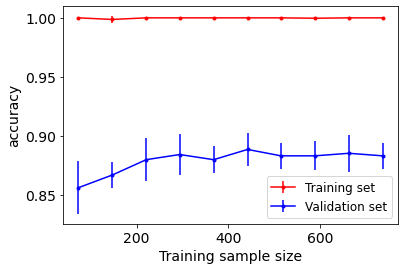

In [19]:
ml.plot_learning_curve(model, X_train, y_train, 'accuracy')

### Teste final do modelo

In [34]:
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
for scorer in [accuracy_score, precision_score, recall_score]:
    print(scorer(y_test, y_test_pred))

0.8711111111111111
0.8895348837209303
0.9386503067484663


In [74]:
# Salva o modelo:
#ml.save_model('../modelos/rf_instagram2twitter_validator_v01/', model, model, train_df, test_df, 'accuracy', 1.00, 0.87, 
#              package_list=['scikit-learn', 'numpy', 'matplotlib', 'pandas', 'scipy'])

## Aplicando modelo aos instagrams

In [57]:
# Seleciona candidatos com insta mas sem twitter:
only_instagram_df = instagram_df.loc[~instagram_df['SQ_CANDIDATO'].isin(twitter_df['SQ_CANDIDATO'])]

In [61]:
# Pega twitter info a partir do usuário do instagram:
guess_from_instagram_df = get_modelling_info(only_instagram_df, 'instagram_user')
guess_from_instagram_df['SQ_CANDIDATO'] = guess_from_instagram_df['SQ_CANDIDATO'].astype(int)  

In [62]:
# Junta informações do candidato:
label_cols = ['NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'SG_PARTIDO', 'SG_UF', 'NR_CANDIDATO']
guess_cand_df = guess_from_instagram_df.join(cand_df.set_index('SQ_CANDIDATO')[label_cols], on='SQ_CANDIDATO')
guess_cand_df['label'] = guess_cand_df['SQ_CANDIDATO'].astype(str) + ': ' + guess_cand_df['NM_URNA_CANDIDATO'] + ' (' + guess_cand_df['SG_PARTIDO'] + '-' + guess_cand_df['SG_UF'] + ') ' + guess_cand_df['NR_CANDIDATO'].astype(str)
len(guess_cand_df)

1994

In [63]:
# Prediz se usuário é o correto:
guess_is_cand = model.predict(guess_cand_df)
guess_is_cand.sum()

1006

In [66]:
cand_df.query('NR_CANDIDATO == 4589')[['SQ_CANDIDATO'] + label_cols]

,SQ_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,SG_PARTIDO,SG_UF,NR_CANDIDATO
7963,60001636093,EDSON BEZERRA DA COSTA,PASTOR EDSON BEZERRA,PSDB,CE,4589
9087,130001613374,ANA PAULA DE OLIVEIRA COSTA MARTINS,ANA COSTA,PSDB,MG,4589
13407,90001621640,REINALDO ALVES DOS SANTOS,DR. REINALDO,PSDB,GO,4589
20493,60001723404,EDSON BEZERRA DA COSTA,PASTOR EDSON BEZERRA,PSDB,CE,4589


In [67]:
redes_df.query('SQ_CANDIDATO == 160001723228')

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,SQ_CANDIDATO,NR_ORDEM,DS_URL,...,abre.bio,gettr,beacons,vaquinhaeleitoral,linklist,nenhuma,email,website,arroba,usuario
11235,16/08/2022,06:08:16,2022,2,ELEIÇÃO ORDINÁRIA,546,ELEIÇÕES GERAIS ESTADUAIS 2022,160001723228,4,https://www.tiktok.com/@danielbrosttoficial,...,0,0,0,0,0,0,0,0,0,0
19922,16/08/2022,06:08:16,2022,2,ELEIÇÃO ORDINÁRIA,546,ELEIÇÕES GERAIS ESTADUAIS 2022,160001723228,5,https://www.facebook.com/danielbrostt,...,0,0,0,0,0,0,0,0,0,0
24189,16/08/2022,06:08:16,2022,2,ELEIÇÃO ORDINÁRIA,546,ELEIÇÕES GERAIS ESTADUAIS 2022,160001723228,3,https://www.linkedin.com/in/edsonbrostt/,...,0,0,0,0,0,0,0,0,0,0
28603,16/08/2022,06:08:16,2022,2,ELEIÇÃO ORDINÁRIA,546,ELEIÇÕES GERAIS ESTADUAIS 2022,160001723228,2,https://www.youtube.com/channel/UC4ecX1xPSNYiC...,...,0,0,0,0,0,0,0,0,0,0
32989,16/08/2022,06:08:16,2022,2,ELEIÇÃO ORDINÁRIA,546,ELEIÇÕES GERAIS ESTADUAIS 2022,160001723228,1,https://www.instagram.com/danielbrostt,...,0,0,0,0,0,0,0,0,0,0


In [71]:
guess_cand_df.loc[(guess_is_cand == 1) & (guess_cand_df['username'] == 'tabataamaralsp')]

,description,name,verified,username,id,created_at,protected,lower_name,SQ_CANDIDATO,instagram_url,...,listed_count,days_created,digits_name,digits_desc,NM_CANDIDATO,NM_URNA_CANDIDATO,SG_PARTIDO,SG_UF,NR_CANDIDATO,label
1399,📚 Ativista pela educação\n➡️ Deputada Federal ...,Tabata Amaral,1,tabataamaralsp,1001251931812220928,2018-05-29T00:00:37.000Z,0,tabataamaralsp,250001620281,https://instagram.com/tabataamaralsp,...,1004,1541.999572,0.0,4.0,TABATA CLAUDIA AMARAL DE PONTES,TABATA AMARAL,PSB,SP,4040,250001620281: TABATA AMARAL (PSB-SP) 4040


In [68]:
# Teste manual:
print_string_series(('https://www.twitter.com/' + guess_cand_df.set_index('label').loc[guess_is_cand == 0, 'username'] + '  https://www.instagram.com/' + guess_cand_df.set_index('label').loc[guess_is_cand == 0, 'username']).sample(20, random_state=1))

50001620961: DANY ADEODATO (PDT-BA) 12007: https://www.twitter.com/DanyAdeodato  https://www.instagram.com/DanyAdeodato
130001615268: PROFESSOR PYRAMIDES (PSOL-MG) 50250: https://www.twitter.com/nenhumdireito  https://www.instagram.com/nenhumdireito
110001618201: VICTÓRIO GALLI (PTB-MT) 1422: https://www.twitter.com/victoriogalli  https://www.instagram.com/victoriogalli
250001612006: DOMENICO DONINA (PP-SP) 1114: https://www.twitter.com/DomenicoDonina  https://www.instagram.com/DomenicoDonina
140001721223: SARGENTO BM RIVELINO (PRTB-PA) 28222: https://www.twitter.com/VilhenaRoberto  https://www.instagram.com/VilhenaRoberto
220001600369: FELIPE FAVA (PTB-RO) 14022: https://www.twitter.com/FelipeFava2  https://www.instagram.com/FelipeFava2
160001621991: RAFAEL NOGUTI (REDE-PR) 1833: https://www.twitter.com/NogutiRafael  https://www.instagram.com/NogutiRafael
180001601340: DR ROBERTO SILVA (SOLIDARIEDADE-PI) 7776: https://www.twitter.com/DrRobertosilva  https://www.instagram.com/DrRoberto

**RESULTADOS**
* 87% +/- 5% de precisão, medidos em 42 casos verificados manualmente.

## Verificando ausência de overlap

In [9]:
dirs = glob('../pretest_tweets/logs/capture/*')

In [11]:
logs = [pd.read_csv(f) for f in dirs]

In [15]:
sets = [set(df['id']) for df in logs]

In [22]:
len(sets[0] & sets[2]) / len(sets[0])

0.5901960784313726

# Lixo

## Criando tabela de comparação twitter instagram

In [ ]:
comparison_df['w_same'] = comparison_df['same'] * comparison_df['n_instagram']

### Dados de candidatos e comentadores

In [128]:
dep_df = request_twitter_user_info(twitter_df, 'twitter_user')

In [142]:
mentions_files = list(Path('../pretest_tweets/data/').rglob('*.csv'))
mentions_df = pd.concat([pd.read_csv(f) for f in mentions_files], ignore_index=True)
nodep_mentions_df = mentions_df.loc[~mentions_df['author_id'].isin(dep_df['id'])]

In [147]:
nodep_users_df = nodep_mentions_df['author_username'].drop_duplicates().reset_index()
nodep_df = request_twitter_user_info(nodep_users_df, 'author_username', 'index')

## Construindo o modelo

In [370]:
vocab = ['candidato', 'dep', 'estadual', 'federal', 'deputado', 'deputada', 'distrital', 'candidata', 'candidatura', 'parlamentar']

def only_letters_f(series):
    return series.apply(xt.keep_only_letters)
only_letters = FunctionTransformer(only_letters_f)
def no_accents_f(series):
    return series.apply(xt.remove_accents)
no_accents = FunctionTransformer(no_accents_f)
def no_punct_f(series):
    return series.apply(lambda x: xt.remove_punctuation(x, whitespace=True))
no_punct = FunctionTransformer(no_punct_f)

#stopwords = list(no_punct_f(no_accents_f(only_letters_f(pd.Series(xt.return_pt_stopwords())))))

#txt  = Pipeline([('let', only_letters), ('acc', no_accents), ('pun', no_punct), ('vec', vec)])